In [1]:
import timm
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Constants

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
EPOCHS = 50
RANDOM_SEED = 44

data_dir = '/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset'
stats_dir = '/kaggle/input/stats-liver/stats_liver (1).csv'
generator = torch.Generator().manual_seed(RANDOM_SEED)

df = pd.read_csv(stats_dir)
MEAN = list(df['Mean'])
STD = list(df['Standard Deviation'])

print(f'Mean: {MEAN}\nSTD: {STD}')

TRANSFORMS = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

Mean: [0.083514534, 0.083514534, 0.083514534]
STD: [0.13147554, 0.13147554, 0.13147554]


In [3]:
# Seed environment

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
# Data

dataset = datasets.ImageFolder(data_dir, transform=TRANSFORMS)
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1], generator=generator)
print(f'Train: {len(train_set)}\nVal:{len(val_set)}\nTest: {len(test_set)}')

Train: 5059
Val:632
Test: 632


In [5]:
# Modules

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "hf_hub:timm/vit_base_patch16_224.augreg2_in21k_ft_in1k",
            features_only=True,
            pretrained=True
        )

    def forward(self, x):
        feats = self.backbone(x)[-1]
        return feats

class ProjectionHead(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_dim, 384),
            nn.BatchNorm1d(384),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(384, 192),
            nn.BatchNorm1d(192),
            nn.Dropout(0.1)
        )
        self._initialize_weights()

    def forward(self, x):
        return self.head(x)

    def _initialize_weights(self):
        for m in self.head:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07, class_weights=None):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.class_weights = class_weights

    def forward(self, features, labels):
        device = features.device
        batch_size = features.shape[0]

        features = F.normalize(features, dim=1)

        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        mask = torch.eye(batch_size, dtype=torch.bool).to(device)
        similarity_matrix.masked_fill_(mask, -1e9)

        labels = labels.contiguous().view(-1, 1)
        match_mask = torch.eq(labels, labels.T).float().to(device)
        match_mask = match_mask * (~mask)

        log_prob = F.log_softmax(similarity_matrix, dim=1)

        numerator = (match_mask * log_prob).sum(1)
        denominator = match_mask.sum(1).clamp(min=1e-6)
        loss = -numerator / denominator

        if self.class_weights is not None:
            sample_weights = self.class_weights[labels.squeeze()]
            loss = loss * sample_weights / sample_weights.mean()

        return loss.mean()


In [6]:
encoder = Encoder().to(device)
proj_head = ProjectionHead(in_dim=768).to(device)
optimizer = optim.AdamW(list(encoder.parameters()) + list(proj_head.parameters()), lr=3e-4, weight_decay=1e-4)
counts = torch.tensor([2114,861,793,857,1698], dtype=torch.float32).to(device)
class_weights = 1.0 / counts
class_weights = class_weights / class_weights.mean()
loss_fn = SupConLoss(class_weights=class_weights)

config.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [7]:
# Training

PATIENCE = 5
min_loss = float('inf')
bad_epochs = 0
MIN_DELTA = 0.05

train_loss_array = []
val_loss_array = []

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=3, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=3, pin_memory=True, shuffle=False)

for epoch in range(EPOCHS):
    print(f'Epoch: {epoch + 1}/{EPOCHS}')
    encoder.train()
    proj_head.train()
    train_loss_total = 0
    for imgs, labels in tqdm(train_loader, desc='Training'):
        imgs, labels = imgs.to(device), labels.to(device)
        features = torch.mean(encoder(imgs), dim=(2, 3))
        proj_features = proj_head(features)
        loss = loss_fn(proj_features, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_total += loss.item()

    train_loss = train_loss_total / len(train_loader) 

    encoder.eval()
    proj_head.eval()
    val_loss_total = 0
    with torch.inference_mode():
        for imgs, labels in tqdm(val_loader, desc='Validation'):
            imgs, labels = imgs.to(device), labels.to(device)
            features = torch.mean(encoder(imgs), dim=(2, 3))
            proj_features = proj_head(features)
            loss = loss_fn(proj_features, labels)
            val_loss_total += loss.item()
    
    val_loss = val_loss_total / len(val_loader)

    print(f'Training Loss: {train_loss}, Validation Loss: {val_loss}')
    train_loss_array.append(train_loss)
    val_loss_array.append(val_loss)

    if val_loss > min_loss * (1 + MIN_DELTA):
        bad_epochs += 1

    elif val_loss < min_loss:
        bad_epochs = 0
        torch.save(encoder.state_dict(), 'best_encoder_con.pth')
        torch.save(proj_head.state_dict(), 'best_proj_head_con.pth')

    else:
        bad_epochs = 0

    if bad_epochs >= PATIENCE:
        print('Early stopping triggered!')
        break

Epoch: 1/50


Validation: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Training Loss: 5.2203741550445555, Validation Loss: 6.283767461776733
Epoch: 2/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


Training Loss: 4.455066460371017, Validation Loss: 7.01088171005249
Epoch: 3/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Training Loss: 4.270243415911682, Validation Loss: 6.339722728729248
Epoch: 4/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Training Loss: 4.082512933015823, Validation Loss: 4.278501200675964
Epoch: 5/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Training Loss: 4.061998030543327, Validation Loss: 4.658504056930542
Epoch: 6/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Training Loss: 3.6693071890484132, Validation Loss: 3.9826382875442503
Epoch: 7/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Training Loss: 3.703082597255707, Validation Loss: 4.721632051467895
Epoch: 8/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Training Loss: 3.833940473198891, Validation Loss: 3.6353954553604124
Epoch: 9/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Training Loss: 3.576979401707649, Validation Loss: 3.800350213050842
Epoch: 10/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Training Loss: 3.768789127469063, Validation Loss: 4.173070096969605
Epoch: 11/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Training Loss: 3.5148309648036955, Validation Loss: 3.511130118370056
Epoch: 12/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Training Loss: 3.2043115586042403, Validation Loss: 3.332445192337036
Epoch: 13/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Training Loss: 3.014113563918182, Validation Loss: 3.1049572944641115
Epoch: 14/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Training Loss: 2.911219910318752, Validation Loss: 2.936489534378052
Epoch: 15/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Training Loss: 2.7949178186146946, Validation Loss: 2.982595610618591
Epoch: 16/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Training Loss: 2.756549745798111, Validation Loss: 2.8464261293411255
Epoch: 17/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Training Loss: 2.6822943687438965, Validation Loss: 2.6990765571594237
Epoch: 18/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Training Loss: 2.57973737034481, Validation Loss: 2.5968127727508543
Epoch: 19/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Training Loss: 2.502039435505867, Validation Loss: 2.56313841342926
Epoch: 20/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Training Loss: 2.4847657561302183, Validation Loss: 2.601292681694031
Epoch: 21/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Training Loss: 2.4707478977972643, Validation Loss: 2.6031054496765136
Epoch: 22/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Training Loss: 2.4392578452825546, Validation Loss: 2.5190653085708616
Epoch: 23/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Training Loss: 2.4198217833456512, Validation Loss: 2.5319400787353517
Epoch: 24/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Training Loss: 2.4223921269178392, Validation Loss: 2.514675164222717
Epoch: 25/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Training Loss: 2.4607643872499465, Validation Loss: 4.246524620056152
Epoch: 26/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Training Loss: 4.693983058059713, Validation Loss: 4.1706116676330565
Epoch: 27/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


Training Loss: 4.044358488917351, Validation Loss: 3.5894598722457887
Epoch: 28/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Training Loss: 3.761617365479469, Validation Loss: 5.754899549484253
Epoch: 29/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Training Loss: 3.5039905667304994, Validation Loss: 3.5392141103744508
Epoch: 30/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Training Loss: 3.2725992083549498, Validation Loss: 3.2517900705337524
Epoch: 31/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Training Loss: 3.1734633564949037, Validation Loss: 3.163444757461548
Epoch: 32/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Training Loss: 2.98576477766037, Validation Loss: 3.0554936647415163
Epoch: 33/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Training Loss: 2.845933789014816, Validation Loss: 2.888183045387268
Epoch: 34/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Training Loss: 2.7781441011113204, Validation Loss: 2.9674215078353883
Epoch: 35/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Training Loss: 2.7378867639455335, Validation Loss: 2.856636118888855
Epoch: 36/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Training Loss: 2.6663908541202543, Validation Loss: 2.8653505563735964
Epoch: 37/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Training Loss: 2.594843527674675, Validation Loss: 2.9445158004760743
Epoch: 38/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Training Loss: 3.550080285853894, Validation Loss: 3.2199944257736206
Epoch: 39/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


Training Loss: 2.91499362885952, Validation Loss: 2.942327857017517
Epoch: 40/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Training Loss: 2.6984344154596327, Validation Loss: 2.981614661216736
Epoch: 41/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Training Loss: 2.6138422220945357, Validation Loss: 2.919010281562805
Epoch: 42/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Training Loss: 2.50576641634456, Validation Loss: 2.7656800031661986
Epoch: 43/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Training Loss: 2.4599129201129504, Validation Loss: 2.640164375305176
Epoch: 44/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Training Loss: 2.4288150548934935, Validation Loss: 2.664832067489624
Epoch: 45/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Training Loss: 2.41946926554665, Validation Loss: 2.6365714073181152
Epoch: 46/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Training Loss: 2.4154969304800034, Validation Loss: 2.649385380744934
Epoch: 47/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


Training Loss: 2.4134698271751405, Validation Loss: 2.6766629457473754
Epoch: 48/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Training Loss: 2.4093998464755715, Validation Loss: 2.652533221244812
Epoch: 49/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Training Loss: 2.417294126749039, Validation Loss: 2.6731921911239622
Epoch: 50/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Training Loss: 2.4338532954454424, Validation Loss: 2.7081114768981935


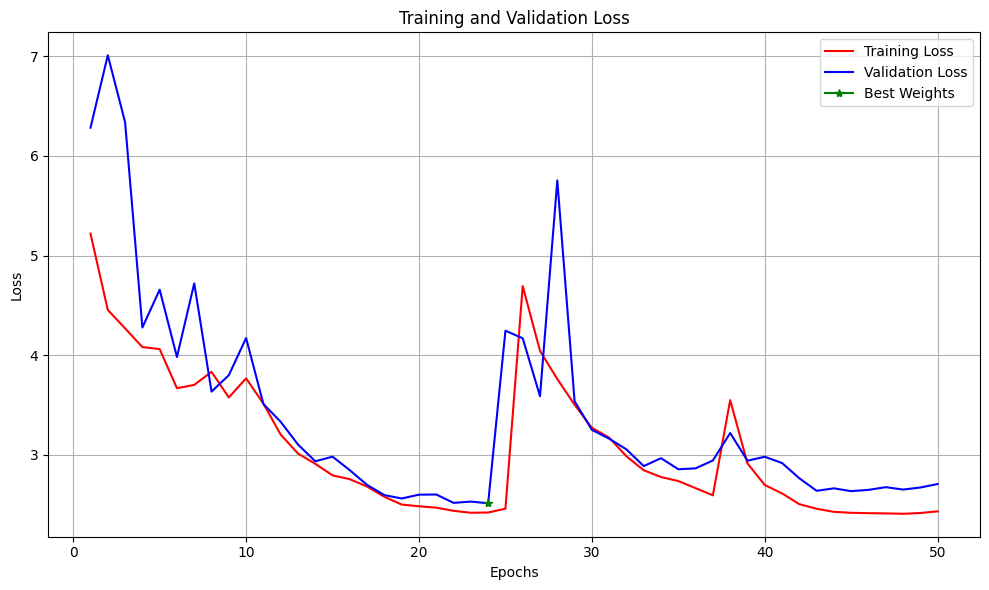

In [8]:
# plot

train_loss_array = np.array(train_loss_array)
val_loss_array = np.array(val_loss_array)
best_weights = np.argmin(val_loss_array)

t = [i + 1 for i in range(len(train_loss_array))]

plt.figure(figsize=(10, 6))
plt.plot(t, train_loss_array, label='Training Loss', color='red')
plt.plot(t, val_loss_array, label='Validation Loss', color='blue')
plt.plot(best_weights + 1, val_loss_array[best_weights], label='Best Weights', color='green', marker='*')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('vit_con_loss_fig.pdf', bbox_inches='tight', format='pdf', dpi=600)
plt.show()